In [ ]:
# For the first try, using old data
def label_cleaning(root_path):
    
    import os
    import numpy as np
    import pandas as pd
    import fnmatch

#     root_path = '/media/share/data/Tremella_fuciformis/'
    dirname = os.listdir(root_path)

    filename = []

    for pname, dname, fname in os.walk(root_path):
        files = fnmatch.filter(fname, '*.xlsx')
        filename.append(files)

    filename = list(filter(None, filename))

    df_all = pd.DataFrame([])
    for i, name in enumerate(dirname):
        subdirpath = os.path.join(root_path, name)
        csvname = fnmatch.filter(os.listdir(subdirpath), '*.xlsx')
        df0 = pd.read_excel(os.path.join(subdirpath, csvname[0]), header=1)

        df_sn = pd.DataFrame([name], columns=['sn'])
        df0_temp = pd.concat([df0['號碼.1'], df0['採收重量']], 1)
        df0_temp = df0_temp.dropna()
        df_temp = pd.concat([df_sn, df0_temp], 1)

        df_all = pd.concat([df_all, df_temp], 0)

    df_all.columns = ['SN', 'CanSN', 'Weight']
    
    return df_all

In [1]:
# For DL purpose, high qulity image
def label_cleaning(root_path):
    
    filename = sorted([idx for idx in Path(root_path).glob('*/*.xlsx')])

    df_all = pd.DataFrame([])
    for idx in filename[:2]:
        df = pd.read_excel(idx, header=1)
        sn = pd.DataFrame(df['號碼.1'].str.split('-').str[0])
        cansn = pd.DataFrame(df['號碼.1'].str.split('-').str[1])
        df_temp = pd.concat([sn, cansn, df['平均單朵重量'], df['取樣天數']], 1)
        df_temp = df_temp.dropna()
        # add production sn
        psn = pd.DataFrame(np.repeat([os.path.basename(idx).split('.')[0]], len(df_temp)), columns=['PSN'])
        df_temp = pd.concat([psn, df_temp], 1)

        df_all = pd.concat([df_all, df_temp], 0)

    df_all.columns = ['PSN', 'SN', 'CanSN', 'Weight', 'Days']
    
    return df_all

# image proprocess

In [84]:
def img_proc(img):
    
    import numpy as np
    from skimage.color import rgb2gray
    from skimage.feature import canny
    from skimage.morphology import disk, closing
    from skimage.morphology import remove_small_objects
    from skimage.measure import label, regionprops
    from skimage.transform import resize

    img1 = rgb2gray(img)
    img2 = canny(img1)
    img3 = closing(img2, disk(5))
    img4 = remove_small_objects(img3)

    # search largest area
    label_img = label(img4)

    bbarea = []
    for region in regionprops(label_img):
        bbarea.append(region.area)

    minr, minc, maxr, maxc = regionprops(label_img)[bbarea.index(np.max(bbarea))].bbox
    crop_img = resize(img[minr:maxr, minc:maxc], [256, 256], mode='constant')
    
    return crop_img

In [68]:
rootpath = '/media/share/data/Tremella_fuciformis/'
from pathlib import Path
import pandas as pd

def label_cleaning(root_path):
    
    filename = sorted([idx for idx in Path(root_path).glob('*/*.xlsx')])

    df_all = pd.DataFrame([])
    for idx in filename[10:]:
        df = pd.read_excel(idx, header=1)
        sn = pd.DataFrame(df['號碼.1'].str.split('-').str[0])
        cansn = pd.DataFrame(df['號碼.1'].str.split('-').str[1])
        df_temp = pd.concat([sn, cansn, df['平均單朵重量'], df['取樣天數']], 1)
        df_temp = df_temp.dropna()
        # add production sn
        psn = pd.DataFrame(np.repeat([os.path.basename(idx).split('.')[0]], len(df_temp)), columns=['PSN'])
        df_temp = pd.concat([psn.reset_index(drop=True), df_temp.reset_index(drop=True)], 1)

        df_all = pd.concat([df_all, df_temp], 0)

    df_all.columns = ['PSN', 'SN', 'CanSN', 'Weight', 'Days']
    
    return df_all


df_train = label_cleaning(rootpath)

# delet mis-matched label
df_train['SN'] = pd.to_numeric(df_train['SN'], errors='coerce')
df_train = df_train.dropna()
df_train['SN'] = pd.to_numeric(df_train['SN'], downcast='integer')

df_train.reset_index(drop=True, inplace=True)

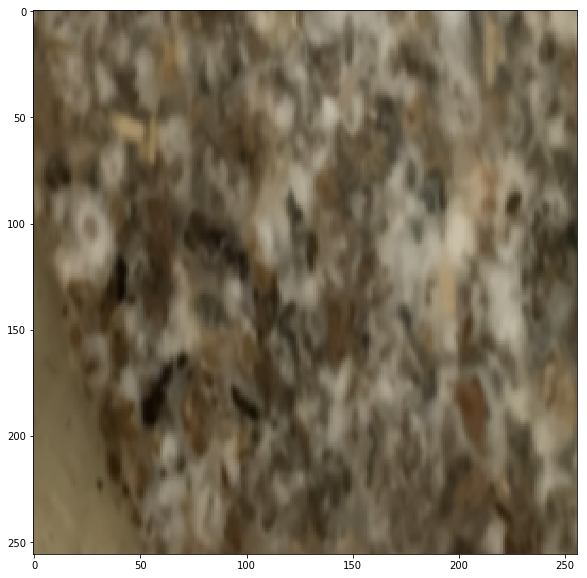

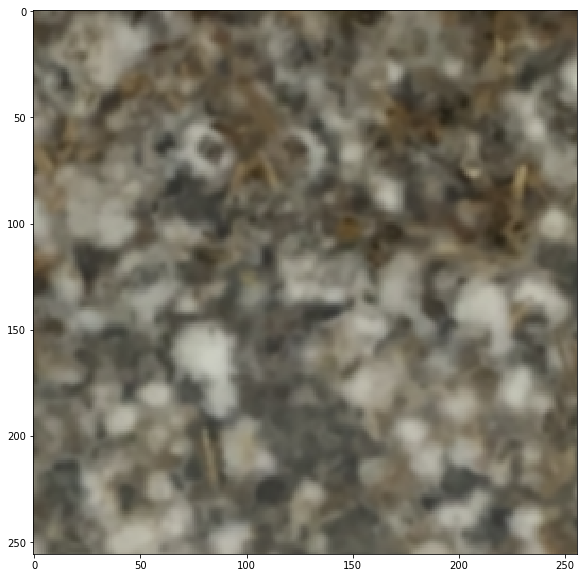

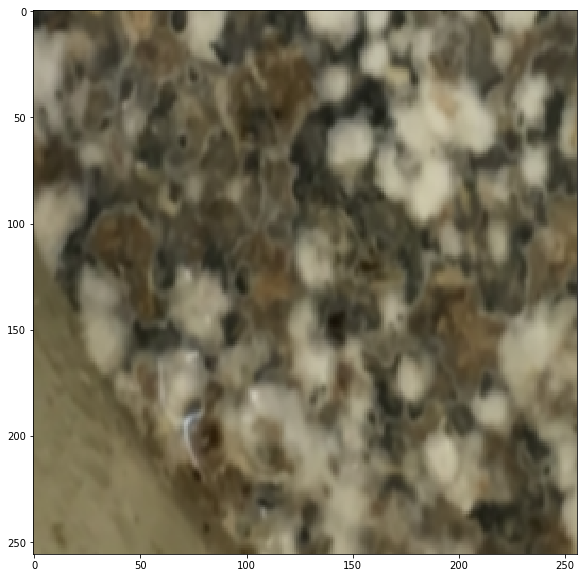

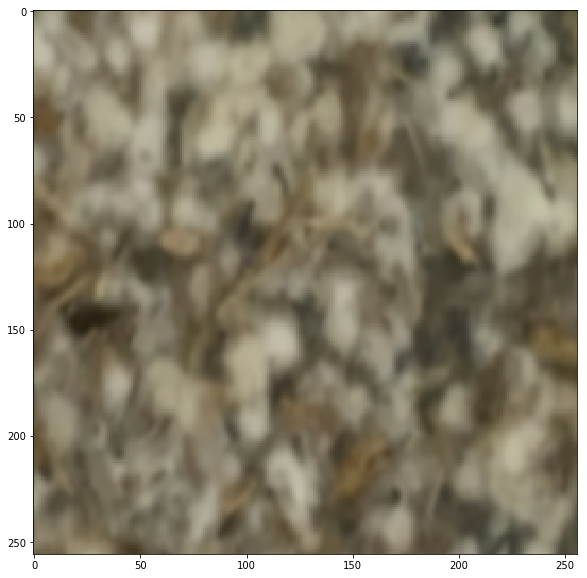

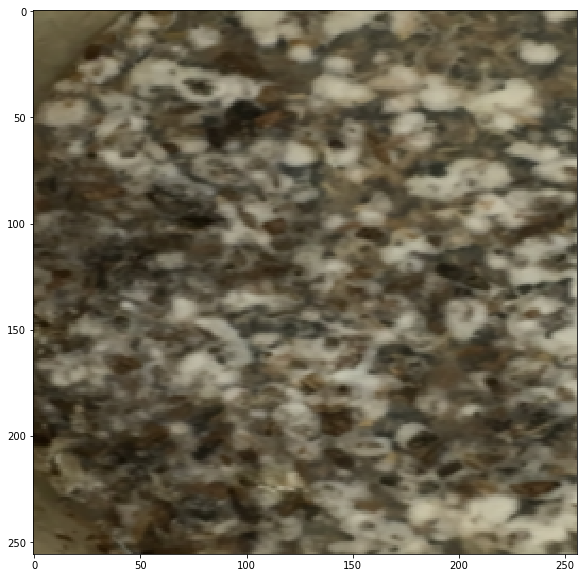

In [90]:
def img_proc(img):
    
    import numpy as np
    from skimage.color import rgb2gray
    from skimage.feature import canny
    from skimage.morphology import disk, closing
    from skimage.morphology import remove_small_objects
    from skimage.measure import label, regionprops

    img1 = rgb2gray(img)
    img2 = canny(img1)
    img3 = closing(img2, disk(5))
    img4 = remove_small_objects(img3)

    # search largest area
    label_img = label(img4)

    bbarea = []
    for region in regionprops(label_img):
        bbarea.append(region.area)

    minr, minc, maxr, maxc = regionprops(label_img)[bbarea.index(np.max(bbarea))].bbox
    crop_img = img[minr:maxr, minc:maxc]
    
    return crop_img


def img_gen(indexlist):
    
    from skimage.transform import resize
    import imgaug as ia
    from imgaug import augmenters as iaa
    from random import shuffle
    
    ia.seed(np.random.randint(1, 2**10))
    
    # aug_parameters
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(
#             scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 90-110% of their size, individually per axis
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            mode='edge'
        ),
        iaa.GaussianBlur((0.0, 1.0))
    ], random_order=True)
    
    step = 0 
    batchsize = 8 * gdev_count
    rows, cols = 256, 256
    
    while True:
        img_file1 = []
        label = []
    
        for i in range(batchsize):
            subpath = os.path.join(rootpath, df_train['PSN'].iloc[indexlist[step]])
            sn = str(df_train['SN'].iloc[indexlist[step]])
            csn = str(df_train['CanSN'].iloc[indexlist[step]])
            img = plt.imread(subpath + '/' + sn + '/' + csn + '.JPG')
            
            if img.shape[0] > img.shape[1]:
                img = np.transpose(img, (1, 0, 2))
                
            # roi segmentation
            img = img_proc(img)

            # augment
            img = seq.augment_image(img)
            
            # resize
            img_file1.append(resize(img, (rows, cols, 3), mode='edge'))

            # load y value
            label.append(df_train['Weight'].iloc[indexlist[step]])
            
            step += 1
            if step >= len(indexlist):
                step = 0

        # yield
        yield np.array(img_file1), np.array(label)